In [ ]:
import numpy as np
import xarray as xr
import os
import glob

def compute_daily_flag_ratio(cloud_paths, byte, start, length, false_values=None):
    """
    Compute daily QA flag ratio across ALL swaths in cloud_paths.
    
    false ratio = (pixels where flag_val in false_values AND cot_use == 1)
                  /
                  (pixels where cot_use == 1)
    """
    if false_values is None:
        false_values = {0}

    total_cot = 0
    total_false = 0

    for path in cloud_paths:
        with xr.open_dataset(path, engine="netcdf4") as ds:
            qa = ds["Quality_Assurance_1km"].astype("uint16")
            byte_arr = qa[:, :, byte]


            # Extract flag
            mask = (1 << length) - 1
            flag_val = (byte_arr >> start) & mask

            # COT use flag
            cot_use = (qa[:, :, 0] >> 0) & 1
            cot_mask = (cot_use == 1)
            n_cot = cot_mask.sum().item()
            if n_cot == 0:
                continue

            

            # false mask for all v in false_values
            false_mask = xr.zeros_like(cot_mask, dtype=bool)
            for v in false_values:
                false_mask = false_mask | (flag_val == v)

            n_false = ((false_mask & cot_mask).sum().item())

            total_cot += n_cot
            total_false += n_false

    if total_cot == 0:
        return np.nan

    return total_false / total_cot

In [562]:
os.chdir("/Users/anora/Library/CloudStorage/Dropbox-TeamMG/Wanru Wu/Cloudseeding_Anora/MODIS_L2")
result = {}


for day in range(1,21):
    day = "{:03d}".format(day)

    cloud_paths = sorted(
        glob.glob(f"MOD06_L2/2020/{day}/MOD06_L2.A2020{day}.*.hdf")
    )
    print("Found", len(cloud_paths), "files")
    dic = {"Primary Cloud Retrieval Phase Flag": (2,0,3,{0}),
        "Primary (VNSWIR - 2.1 μm) Cloud Retrieval Outcome Flag":(2,3,1,{0})}

    daily_results = {}
    print("\n--- Running Daily Flag Ratio Computations ---")
    for flag_name, params in dic.items():
        # 解包参数
        byte, start, length, false_values = params

        print(f"\nProcessing: {flag_name}")
        print(f"  -> Params: byte={byte}, start={start}, length={length}, false_values={false_values}")

        # 调用函数
        ratio = compute_daily_flag_ratio(
            cloud_paths,
            byte=byte,
            start=start,
            length=length,
            false_values=false_values)

        # 存储和打印结果
        daily_results[flag_name] = ratio
        print(f"  -> Daily ratio: {ratio:.6f}" if not np.isnan(ratio) else f"  -> Daily ratio: NaN")
    
    result[day] = daily_results


print(result)   

Found 288 files

--- Running Daily Flag Ratio Computations ---

Processing: Primary Cloud Retrieval Phase Flag
  -> Params: byte=2, start=0, length=3, false_values={0}
  -> Daily ratio: 0.000000

Processing: Primary (VNSWIR - 2.1 μm) Cloud Retrieval Outcome Flag
  -> Params: byte=2, start=3, length=1, false_values={0}
  -> Daily ratio: 0.106695
Found 288 files

--- Running Daily Flag Ratio Computations ---

Processing: Primary Cloud Retrieval Phase Flag
  -> Params: byte=2, start=0, length=3, false_values={0}
  -> Daily ratio: 0.000000

Processing: Primary (VNSWIR - 2.1 μm) Cloud Retrieval Outcome Flag
  -> Params: byte=2, start=3, length=1, false_values={0}
  -> Daily ratio: 0.108270
Found 288 files

--- Running Daily Flag Ratio Computations ---

Processing: Primary Cloud Retrieval Phase Flag
  -> Params: byte=2, start=0, length=3, false_values={0}
  -> Daily ratio: 0.000000

Processing: Primary (VNSWIR - 2.1 μm) Cloud Retrieval Outcome Flag
  -> Params: byte=2, start=3, length=1, fal

In [508]:
# 调用函数
ratio = compute_daily_mask_ratio(
    cloud_paths,
    byte=1,
    start=0,
    length=1,
    false_values={0}
)
print(ratio)

0.8077610103137159


In [558]:
with xr.open_dataset(cloud_paths[0], engine="netcdf4") as ds:
    qa = ds["Quality_Assurance_1km"]
    print("QA shape:", qa.shape)  # 应该是 (行, 列, bytes数)
    print("QA 第三维大小:", qa.shape[2])  # 应该是 9
    
    # 检查第三维的索引范围
    print("第三维坐标:", qa.coords[qa.dims[2]].values)
# 访问第三维的第 5 个切片 (索引为 4)
print(qa[6, 2, 4].values)

QA shape: (2030, 1354, 9)
QA 第三维大小: 9
第三维坐标: [0 1 2 3 4 5 6 7 8]
nan


In [532]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:                                   (Cell_Along_Swath_5km:mod06: 406,
                                               Cell_Across_Swath_5km:mod06: 270,
                                               Band_Number:mod06: 7,
                                               Band_Forcing:mod06: 5,
                                               Band_Ratio:mod06: 5,
                                               Cell_Along_Swath_1km:mod06: 2030,
                                               ...
                                               RadTran_NRE_Liq:mod06: 18,
                                               SPI_nband:mod06: 2,
                                               RFM_nband:mod06: 3,
                                               ACR_nband:mod06: 6,
                                               QA_Parameter_1km:mod06: 9,
                                               fakeDim17: 17)
Dimensions without coordinates: Cell_Along_Swath_5km:mod06,
                                Cell_Across_Swath_5km:mod06, Band_Number:mod06,
                                Band_Forcing:mod06, Band_Ratio:mod06,
                                Cell_Along_Swath_1km:mod06,
                                Cell_Across_Swath_1km:mod06,
                                Cloud_Mask_5km_Num_Bytes:mod06,
                                QA_Parameter_5km:mod06,
                                Cloud_Mask_1km_Num_Bytes:mod06,
                                RadTran_NRE_Ice:mod06, RadTran_NWL:mod06,
                                RadTran_NRE_Liq:mod06, SPI_nband:mod06,
                                RFM_nband:mod06, ACR_nband:mod06,
                                QA_Parameter_1km:mod06, fakeDim17
Data variables: (12/127)
    Latitude                                  (Cell_Along_Swath_5km:mod06, Cell_Across_Swath_5km:mod06) float64 877kB ...
    Longitude                                 (Cell_Along_Swath_5km:mod06, Cell_Across_Swath_5km:mod06) float64 877kB ...
    Scan_Start_Time                           (Cell_Along_Swath_5km:mod06, Cell_Across_Swath_5km:mod06) datetime64[ns] 877kB ...
    Solar_Zenith                              (Cell_Along_Swath_5km:mod06, Cell_Across_Swath_5km:mod06) float64 877kB ...
    Solar_Zenith_Day                          (Cell_Along_Swath_5km:mod06, Cell_Across_Swath_5km:mod06) float64 877kB ...
    Solar_Zenith_Night                        (Cell_Along_Swath_5km:mod06, Cell_Across_Swath_5km:mod06) float64 877kB ...
    ...                                        ...
    Retrieval_Failure_Metric_16               (Cell_Along_Swath_1km:mod06, Cell_Across_Swath_1km:mod06, RFM_nband:mod06) float64 66MB ...
    Retrieval_Failure_Metric_37               (Cell_Along_Swath_1km:mod06, Cell_Across_Swath_1km:mod06, RFM_nband:mod06) float64 66MB ...
    Retrieval_Failure_Metric_1621             (Cell_Along_Swath_1km:mod06, Cell_Across_Swath_1km:mod06, RFM_nband:mod06) float64 66MB ...
    Atm_Corr_Refl                             (Cell_Along_Swath_1km:mod06, Cell_Across_Swath_1km:mod06, ACR_nband:mod06) float64 132MB ...
    Quality_Assurance_1km                     (Cell_Along_Swath_1km:mod06, Cell_Across_Swath_1km:mod06, QA_Parameter_1km:mod06) float64 198MB ...
    Statistics_1km_sds                        (fakeDim17) float32 68B ...
Attributes: (12/14)
    HDFEOSVersion:                     HDFEOS_V2.19
    StructMetadata.0:                  GROUP=SwathStructure\n\tGROUP=SWATH_1\...
    Number_of_Instrument_Scans:        2030
    Maximum_Number_of_1km_Frames:      1354
    history:                           $Id: MOD06_L2.CDL.fs,v 1.13 2013/06/19...
    title:                             MODIS Level 2 Cloud Properties        ...
    ...                                ...
    Clear_Sky_Restoral_Status:         y
    Collection_4_Phase_Used:           n
    Ice_Phase_Forced:                  n
    Water_Phase_Forced:                n
    identifier_product_doi:            10.5067/MODIS/MOD06_L2.061
    i

In [621]:
np.array([[0,1],[2,3]])[0, 1]

1

In [566]:
qa = np.array([np.nan,np.nan]).astype("uint16")
qa

array([0, 0], dtype=uint16)

In [567]:
# 精筛选：在江西 boundary 内
import geopandas as gpd
from shapely import MultiPolygon 

In [606]:
os.chdir("/Users/anora/Library/CloudStorage/Dropbox-TeamMG/Wanru Wu/Cloudseeding_Anora/MODIS_L2")

# load data
townshape = gpd.read_file('/Users/anora/Library/CloudStorage/Dropbox-TeamMG/Wanru Wu/Cloudseeding_Anora/township_shapefile/xiangzhen.shp')

# data clean
townshape = townshape[townshape['省'] == "江西省"]
townshape = townshape[['省','市','县','乡','geometry']]
townshape.columns = ["prov","city","county","town","geometry"]
townshape = townshape.reset_index(drop=True)
townshape["geometry"] = townshape["geometry"].buffer(0)

# Two types exists: polygon and multipolygon, all convert 
# to multipolygon to avoid geometry issues
townshape['geometry'] = townshape['geometry'].apply(
    lambda g: MultiPolygon([g]) if g.geom_type == 'Polygon' else g
)
# Dissolve
jiangxi_shape = townshape.dissolve()[['geometry','prov']].to_crs('EPSG:4326')
jx_poly = jiangxi_shape.geometry.iloc[0]

In [612]:
ys = [28,26,17]
xs = [115,117,118]

points = gpd.GeoSeries(gpd.points_from_xy(xs, ys), crs="EPSG:4326")
inside = points.intersects(jx_poly)
inside.values.reshape(3,1)

array([[ True],
       [False],
       [False]])

In [609]:
list(zip(xs, ys))

[(115, 28), (117, 26), (118, 17)]

In [623]:
# load data
townshape = gpd.read_file('/Users/anora/Library/CloudStorage/Dropbox-TeamMG/Wanru Wu/Cloudseeding_Anora/township_shapefile/xiangzhen.shp')

# data clean
townshape = townshape[townshape['省'] == "江西省"]
townshape = townshape[['省','市','县','乡','geometry']]
townshape.columns = ["prov","city","county","town","geometry"]
townshape = townshape.reset_index(drop=True)
townshape["geometry"] = townshape["geometry"].buffer(0)

# Two types exists: polygon and multipolygon, all convert 
# to multipolygon to avoid geometry issues
townshape['geometry'] = townshape['geometry'].apply(
    lambda g: MultiPolygon([g]) if g.geom_type == 'Polygon' else g
)
# Dissolve
jiangxi_shape = townshape.dissolve()[['geometry','prov']].to_crs('EPSG:4326')
jiangxi_shape.to_file('/Users/anora/Library/CloudStorage/Dropbox-TeamMG/Wanru Wu/Cloudseeding_Anora/jiangxi/jiangxi_shape.shp')

In [4]:
import pickle
path = "/Users/anora/Desktop/modis_panel_2020.feather"
import pandas as pd

import pyarrow.feather as ft
import pyarrow as pa

tbl = ft.read_table(path)
df = tbl.to_pandas(types_mapper=pd.ArrowDtype)

len(df["value_interpolated"].unique())

path = '/Users/anora/Library/CloudStorage/Dropbox-TeamMG/Wanru Wu/Cloudseeding_Anora/MODIS_L2/modis_panel_2020.pkl'
df = pd.read_pickle(path)
df

,year,day,var,cell_i,cell_j,cell_id,x_center,y_center,value_interpolated,value_raw
0,2020,1,Cloud_Fraction,0,0,0_0,3.916386e+07,2.714380e+06,NaN,NaN
1,2020,1,Cloud_Fraction,0,1,0_1,3.916886e+07,2.714380e+06,NaN,NaN
2,2020,1,Cloud_Fraction,0,2,0_2,3.917386e+07,2.714380e+06,NaN,NaN
3,2020,1,Cloud_Fraction,0,3,0_3,3.917886e+07,2.714380e+06,NaN,NaN
4,2020,1,Cloud_Fraction,0,4,0_4,3.918386e+07,2.714380e+06,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
24051,2020,1,Cloud_Optical_Thickness,123,92,123_92,3.962386e+07,3.329380e+06,NaN,NaN
24052,2020,1,Cloud_Optical_Thickness,123,93,123_93,3.962886e+07,3.329380e+06,NaN,NaN
24053,2020,1,Cloud_Optical_Thickness,123,94,123_94,3.963386e+07,3.329380e+06,NaN,NaN
24054,2020,1,Cloud_Optical_Thickness,123,95,123_95,3.963886e+07,3.329380e+06,NaN,NaN


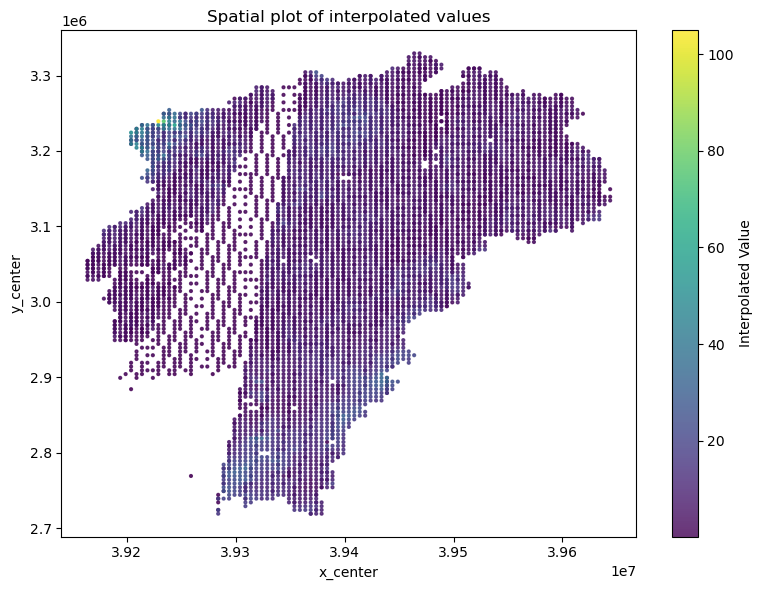

In [6]:
import matplotlib.pyplot as plt
import numpy as np

df_plot = df.copy()

plt.figure(figsize=(8, 6))

sc = plt.scatter(
    df_plot["x_center"], 
    df_plot["y_center"], 
    c=df_plot["value_raw"],
    cmap="viridis",
    s=4,               # point size
    alpha=0.8
)

plt.colorbar(sc, label="Interpolated Value")
plt.xlabel("x_center")
plt.ylabel("y_center")
plt.title("Spatial plot of interpolated values")
plt.tight_layout()
plt.show()